# Using Satellite Imagery and Machine Learning for Urban Heat Risk Analysis in San Francisco

> Background

    Urban heat risk is a growing concern in many cities around the world, including San Francisco. The rapid urbanization and industrialization of San Francisco. have led to the emergence of urban heat islands, characterized by higher temperatures in densely built-up areas compared to surrounding suburban areas. This phenomenon poses significant health risks to residents, especially during heat waves, and can exacerbate existing socioeconomic inequalities.

> Problem Statement

    The main objective of this project is to assess the urban heat risk in San Francisco. over the past 5 years using satellite imagery and machine learning. The analysis will identify areas with high heat risk and help city planners and policymakers implement targeted interventions to reduce heat exposure, particularly for vulnerable populations.

> Dataset

    For this project, I will use publicly available Landsat 8 satellite imagery through the Google Earth Engine of San Francisco in 2020. The Landsat 8 images provide high-resolution (30-meter) data in multiple spectral bands, including the thermal infrared band, which is essential for calculating land surface temperature. Then I use Python script that utilizes the Google Earth Engine (GEE) Python API to download Landsat 8 satellite imagery for the year 2020 over San Francisco with less than 5% cloud cover. The script loops through each image in the resulting image collection, exports them as GeoTIFF files, and uploads them to a Google Cloud Storage bucket named ‘sf_imagery’. Moreover, GeoTIFF images can be extracted from the specified Google Cloud Storage bucket.

In [3]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 36.6 MB/s eta 0:00:00


# １. Import

In [5]:
import sys
import os
import ee
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from rasterio.mask import mask
from rasterio.features import geometry_mask
from rasterio.transform import from_bounds
import rasterio
import fsspec
import requests
from io import BytesIO
import zipfile

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    roc_curve,
    f1_score
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

ee.Authenticate()
ee.Initialize(project='sfurbanheatisland')


In [19]:

# Initialize Earth Engine
ee.Initialize(project='sfurbanheatisland')  # Update with YOUR project name


## Overview

In this section, it generates a set of satellite-derived vegetation indices including Normalized Difference Vegetation Index (NDVI), Normalized Difference Built-Up Index (NDBI), Normalized Difference Water Index (NDWI), Built-Up Index (BU), Enhanced Vegetation Index (EVI), and Soil-Adjusted Vegetation Index (SAVI) for a region of interest in San Francisco.

The code first defines the region of San Francisco and filters the Landsat-8 image collection to get the image on September 30th, 2022, with less than 20% cloud cover. It then calculates the median of the filtered image collection and computes the vegetation indices using the normalized difference or expression methods. The vegetation indices are clipped to the region of interest, and then added to a Folium map, along with the San Francisco neighborhood boundaries as a GeoJSON layer. The final output is an interactive map that displays the vegetation indices for the selected area.

In [20]:

# Output directory
OUTPUT_DIR = "./nyc_heat_analysis_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# NYC Bounding Box (Manhattan, Brooklyn, Queens, Bronx)
# Using a simple rectangle that covers the main NYC area
NYC_BOUNDS = {
    'west': -74.3,    # Western edge (includes Staten Island)
    'south': 40.5,    # Southern edge (includes southern Brooklyn)
    'east': -73.65,   # Eastern edge (includes eastern Queens)
    'north': 40.95    # Northern edge (includes the Bronx)
}

# Imagery parameters - Summer 2024 for best heat island effect
START_DATE = '2024-06-01'
END_DATE = '2024-08-31'
CLOUD_COVER_MAX = 20  # NYC often has more clouds, so increased threshold

# ML parameters
TEST_SIZE = 0.3
THRESHOLD_PERCENTILE = 80
RANDOM_SEED = 42


# 2. Data Wrangling

In [21]:
# ----------------------------------------------------------------------------
# 1.1: Define NYC Study Area
# ----------------------------------------------------------------------------
nyc_bounds = [NYC_BOUNDS['west'], NYC_BOUNDS['south'],
              NYC_BOUNDS['east'], NYC_BOUNDS['north']]
print(f"    ✓ Bounds: [{nyc_bounds[0]:.2f}, {nyc_bounds[1]:.2f}, "
      f"{nyc_bounds[2]:.2f}, {nyc_bounds[3]:.2f}]")


1.1 Defining NYC study area...
    ✓ Study area: New York City
    ✓ Bounds: [-74.30, 40.50, -73.65, 40.95]
    ✓ Coverage: Manhattan, Brooklyn, Queens, Bronx, Staten Island


In [22]:

# ----------------------------------------------------------------------------
# 1.2: Download Landsat 8/9 Imagery from Google Earth Engine
# ----------------------------------------------------------------------------

print("\n1.2 Downloading Landsat imagery from Google Earth Engine...")
print(f"    Date range: {START_DATE} to {END_DATE}")
print(f"    Max cloud cover: {CLOUD_COVER_MAX}%")

# Create bounding box
region = ee.Geometry.Rectangle([nyc_bounds[0], nyc_bounds[1],
                                nyc_bounds[2], nyc_bounds[3]])

# Search for Landsat 9 first (newer), then Landsat 8
landsat9 = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2') \
    .filterBounds(region) \
    .filterDate(START_DATE, END_DATE) \
    .filter(ee.Filter.lt('CLOUD_COVER', CLOUD_COVER_MAX)) \
    .sort('CLOUD_COVER')

landsat8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterBounds(region) \
    .filterDate(START_DATE, END_DATE) \
    .filter(ee.Filter.lt('CLOUD_COVER', CLOUD_COVER_MAX)) \
    .sort('CLOUD_COVER')

# Combine collections
landsat_combined = landsat9.merge(landsat8)

count = landsat_combined.size().getInfo()
print(f"    ✓ Found {count} images matching criteria")

if count == 0:
    raise ValueError("No imagery found! Try increasing CLOUD_COVER_MAX or expanding date range.")

# Get the best (least cloudy) image
image = landsat_combined.first()
img_info = image.getInfo()

print(f"\n    Selected image:")
print(f"      ID: {img_info['id']}")
print(f"      Date: {img_info['properties']['DATE_ACQUIRED']}")
print(f"      Cloud cover: {img_info['properties']['CLOUD_COVER']:.2f}%")
print(f"      Satellite: {'Landsat 9' if 'LC09' in img_info['id'] else 'Landsat 8'}")

# Select bands
bands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ST_B10']
image = image.select(bands)

print("\n    Downloading image data (this may take 1-2 minutes)...")
print("    Note: Large area - using reduced resolution for speed")

# Use 90m resolution for NYC (3x Landsat native) for faster processing
scale = 90

print(f"    Resolution: {scale}m (reduced from 30m for speed)")

# Get download URL
download_url = image.getDownloadURL({
    'region': region.coordinates().getInfo(),
    'scale': scale,
    'format': 'GEO_TIFF',
    'bands': bands
})

print(f"    Downloading from Google Earth Engine...")

# Download the file
response = requests.get(download_url)

if response.status_code != 200:
    raise ValueError(f"Download failed with status {response.status_code}")

# Check if response is JSON (contains actual download URL)
try:
    json_response = response.json()
    if 'downloadUrl' in json_response:
        # Need to follow the actual download URL
        actual_url = json_response['downloadUrl']
        print(f"    Following download URL...")
        response = requests.get(actual_url)

        if response.status_code != 200:
            raise ValueError(f"Actual download failed with status {response.status_code}")
except:
    # Response is already the file, not JSON
    pass

print(f"    ✓ Downloaded {len(response.content) / 1024 / 1024:.1f} MB")

# Process the downloaded file
if not response.content[:4] == b'PK\x03\x04':
    # Not a zip file - might be a single GeoTIFF
    print(f"    Processing as single GeoTIFF...")

    # Try to open as GeoTIFF directly
    with rasterio.open(BytesIO(response.content)) as src:
        # Read all bands
        img_arrays = {}
        for i, band in enumerate(bands, start=1):
            if i <= src.count:
                arr = src.read(i)
                img_arrays[band] = arr
                print(f"      ✓ {band}: {arr.shape}")
            else:
                print(f"      ⚠ Band {band} not found in GeoTIFF")
else:
    # It's a ZIP file
    print(f"    Extracting bands from ZIP...")

    img_arrays = {}

    with zipfile.ZipFile(BytesIO(response.content)) as z:
        # List files in zip
        tiff_files = [f for f in z.namelist() if f.endswith('.tif')]

        print(f"    Found {len(tiff_files)} TIFF files in ZIP")

        # Read each band
        for tiff_file in tiff_files:
            # Extract band name from filename
            parts = tiff_file.split('.')
            if len(parts) >= 2:
                band_name = parts[-2]
            else:
                band_name = tiff_file.replace('.tif', '')

            # Read the tiff
            with z.open(tiff_file) as f:
                tiff_bytes = BytesIO(f.read())
                with rasterio.open(tiff_bytes) as src:
                    arr = src.read(1)
                    img_arrays[band_name] = arr
                    print(f"      ✓ {band_name}: {arr.shape}")

# Stack all bands into one array
img = np.stack([img_arrays[b] for b in bands], axis=0)

print(f"\n    ✓ Complete! Image shape: {img.shape}")
print(f"      Bands: {img.shape[0]}, Height: {img.shape[1]}, Width: {img.shape[2]}")



1.2 Downloading Landsat imagery from Google Earth Engine...
    Date range: 2024-06-01 to 2024-08-31
    Max cloud cover: 20%
    ✓ Found 10 images matching criteria

    Selected image:
      ID: LANDSAT/LC09/C02/T1_L2/LC09_013032_20240702
      Date: 2024-07-02
      Cloud cover: 0.44%
      Satellite: Landsat 9

    Note: Large area - using reduced resolution for speed
    Resolution: 90m (reduced from 30m for speed)


    ✓ Downloaded 4.2 MB
    Processing as single GeoTIFF...
      ✓ SR_B2: (563, 618)
      ✓ SR_B3: (563, 618)
      ✓ SR_B4: (563, 618)
      ✓ SR_B5: (563, 618)
      ✓ SR_B6: (563, 618)
      ✓ SR_B7: (563, 618)
      ✓ ST_B10: (563, 618)

    ✓ Complete! Image shape: (7, 563, 618)
      Bands: 7, Height: 563, Width: 618


In [23]:

# ----------------------------------------------------------------------------
# 1.3: Preprocess Data
# ----------------------------------------------------------------------------

print("\n1.3 Preprocessing data...")

# Check raw values
print(f"    Raw values from GEE (before scaling):")
print(f"      Optical band 0 (Blue): min={np.nanmin(img[0]):.0f}, max={np.nanmax(img[0]):.0f}, mean={np.nanmean(img[0]):.0f}")
print(f"      Thermal band 6:        min={np.nanmin(img[6]):.0f}, max={np.nanmax(img[6]):.0f}, mean={np.nanmean(img[6]):.0f}")

# Handle invalid values
img = img.astype(float)
img[img <= 0] = np.nan

# Apply Landsat Collection 2 Level-2 scaling factors
print(f"\n    Applying Landsat Collection 2 scaling factors...")

# Optical bands (SR_B2 through SR_B7): indices 0-5
# Scale factor: 0.0000275, Offset: -0.2
for i in range(6):
    img[i] = img[i] * 0.0000275 - 0.2

# Thermal band (ST_B10): index 6
# Scale factor: 0.00341802, Offset: 149.0 (converts to Kelvin)
img[6] = img[6] * 0.00341802 + 149.0

print(f"    ✓ Applied optical band scaling (indices 0-5)")
print(f"    ✓ Applied thermal band scaling (index 6)")
print(f"    ✓ Thermal band range: {np.nanmin(img[6]):.2f}K to {np.nanmax(img[6]):.2f}K")

# Convert Kelvin to Celsius for better interpretability
thermal_celsius = img[6] - 273.15
print(f"    ✓ Temperature range: {np.nanmin(thermal_celsius):.1f}°C to {np.nanmax(thermal_celsius):.1f}°C")

# Clip optical bands to reasonable range
for i in range(6):
    img[i] = np.clip(img[i], 0, 1)

print(f"    ✓ Clipped optical bands to [0, 1] range")
print(f"    ✓ Final image shape: {img.shape}")

# Count valid pixels
valid_pixels = np.sum(~np.isnan(img[0]))
total_pixels = img.shape[1] * img.shape[2]

print(f"\n    Image coverage statistics:")
print(f"      Total pixels: {total_pixels:,}")
print(f"      Valid pixels: {valid_pixels:,} ({valid_pixels/total_pixels*100:.1f}%)")




1.3 Preprocessing data...
    Raw values from GEE (before scaling):
      Optical band 0 (Blue): min=0, max=29864, mean=9526
      Thermal band 6:        min=0, max=55480, mean=46552

    Applying Landsat Collection 2 scaling factors...
    ✓ Applied optical band scaling (indices 0-5)
    ✓ Applied thermal band scaling (index 6)
    ✓ Thermal band range: 290.79K to 338.63K
    ✓ Temperature range: 17.6°C to 65.5°C
    ✓ Clipped optical bands to [0, 1] range
    ✓ Final image shape: (7, 563, 618)

    Image coverage statistics:
      Total pixels: 347,934
      Valid pixels: 347,646 (99.9%)


# Exploratory Analysis

In [24]:
# ----------------------------------------------------------------------------
# 2.1: Calculate Spectral Indices
# ----------------------------------------------------------------------------

print("2.1 Calculating spectral indices...")

# Extract bands
blue = img[0]
green = img[1]
red = img[2]
nir = img[3]
swir1 = img[4]
swir2 = img[5]
thermal = img[6]

print("    Checking thermal band...")
print(f"      Min: {np.nanmin(thermal):.2f}K, Max: {np.nanmax(thermal):.2f}K, Mean: {np.nanmean(thermal):.2f}K")

# Calculate indices with error handling
with np.errstate(divide='ignore', invalid='ignore'):
    # Normalized Difference Vegetation Index
    NDVI = (nir - red) / (nir + red)

    # Normalized Difference Built-up Index
    NDBI = (swir1 - nir) / (swir1 + nir)

    # Normalized Difference Water Index
    NDWI = (nir - swir1) / (nir + swir1)

    # Built-Up Index (difference)
    BU = NDBI - NDVI

    # Enhanced Vegetation Index
    G, C1, C2, L = 2.5, 6, 7.5, 1
    EVI = G * ((nir - red) / (nir + C1 * red - C2 * blue + L))

    # Soil-Adjusted Vegetation Index
    L = 0.5
    SAVI = ((nir - red) / (nir + red + L)) * (1 + L)

    # Land Surface Temperature - Convert from Kelvin to Celsius
    LST = thermal - 273.15
    print(f"    LST: Converted from Kelvin → Celsius (range: {np.nanmin(LST):.1f}°C to {np.nanmax(LST):.1f}°C)")


print("    ✓ Calculated 7 spectral indices:")
print("      - NDVI: Vegetation presence")
print("      - NDBI: Built-up/urban areas")
print("      - NDWI: Water bodies")
print("      - BU: Urban intensity")
print("      - EVI: Enhanced vegetation")
print("      - SAVI: Soil-adjusted vegetation")
print("      - LST: Surface temperature")



2.1 Calculating spectral indices...
    Checking thermal band...
      Min: 290.79K, Max: 338.63K, Mean: 308.25K
    LST: Converted from Kelvin → Celsius (range: 17.6°C to 65.5°C)
    ✓ Calculated 7 spectral indices:
      - NDVI: Vegetation presence
      - NDBI: Built-up/urban areas
      - NDWI: Water bodies
      - BU: Urban intensity
      - EVI: Enhanced vegetation
      - SAVI: Soil-adjusted vegetation
      - LST: Surface temperature


In [25]:

# ----------------------------------------------------------------------------
# 2.2: Descriptive Statistics
# ----------------------------------------------------------------------------

print("\n2.2 Descriptive statistics:")

indices = {
    'NDVI': NDVI,
    'NDBI': NDBI,
    'NDWI': NDWI,
    'BU': BU,
    'EVI': EVI,
    'SAVI': SAVI,
    'LST': LST
}

stats_list = []
for name, data in indices.items():
    valid_data = data[~np.isnan(data)]
    if len(valid_data) > 0:
        stats = {
            'Index': name,
            'Mean': np.mean(valid_data),
            'Std': np.std(valid_data),
            'Min': np.min(valid_data),
            'Max': np.max(valid_data)
        }
        stats_list.append(stats)

        # Format output based on index type
        if name == 'LST':
            print(f"    {name:6s}: Mean={stats['Mean']:7.1f}°C, Std={stats['Std']:6.1f}, "
                  f"Min={stats['Min']:7.1f}°C, Max={stats['Max']:7.1f}°C")
        else:
            print(f"    {name:6s}: Mean={stats['Mean']:7.3f}, Std={stats['Std']:6.3f}, "
                  f"Min={stats['Min']:7.3f}, Max={stats['Max']:7.3f}")

# Create summary table
stats_df = pd.DataFrame(stats_list)



2.2 Descriptive statistics:
    NDVI  : Mean=  0.114, Std= 0.623, Min= -1.000, Max=  1.000
    NDBI  : Mean= -0.020, Std= 0.392, Min= -1.000, Max=  1.000
    NDWI  : Mean=  0.020, Std= 0.392, Min= -1.000, Max=  1.000
    BU    : Mean= -0.250, Std= 0.906, Min= -1.934, Max=  2.000
    EVI   : Mean=  0.233, Std= 0.225, Min= -0.269, Max=  0.970
    SAVI  : Mean=  0.207, Std= 0.200, Min= -0.153, Max=  0.785
    LST   : Mean=   35.1°C, Std=   9.0, Min=   17.6°C, Max=   65.5°C


In [26]:


# ----------------------------------------------------------------------------
# 2.3: Visualize Spatial Distribution
# ----------------------------------------------------------------------------

print("\n2.3 Creating spatial distribution maps...")

# Create figure with better layout for NYC
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

plot_indices = ['NDVI', 'NDBI', 'LST', 'NDWI', 'BU', 'EVI', 'SAVI']

for idx, (ax, name) in enumerate(zip(axes, plot_indices)):
    data = indices[name]

    # Choose colormap based on index
    if name == 'NDVI' or name == 'EVI' or name == 'SAVI':
        cmap = 'RdYlGn'  # Green for vegetation
    elif name == 'LST':
        cmap = 'hot_r'  # Temperature colormap
    elif name == 'NDWI':
        cmap = 'Blues'  # Blue for water
    else:
        cmap = 'RdYlGn_r'  # Red for built-up/heat

    # Plot with NaN handling
    masked_data = np.ma.masked_invalid(data)
    im = ax.imshow(masked_data, cmap=cmap, aspect='auto')
    ax.set_title(f'{name}', fontsize=12, fontweight='bold')
    ax.axis('off')

    # Add colorbar with appropriate label
    if name == 'LST':
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('°C', rotation=0, labelpad=10)
    else:
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Hide the last subplot
axes[-1].axis('off')
axes[-1].text(0.5, 0.5, 'NYC Urban Heat Analysis\n\nKey Areas:\n• Manhattan (center)\n• Brooklyn (south)\n• Queens (east)\n• Bronx (north)\n• Staten Island (southwest)',
              ha='center', va='center', fontsize=12, transform=axes[-1].transAxes)

plt.suptitle('Spectral Indices - New York City', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/01_spatial_distribution.png', dpi=300, bbox_inches='tight')
print(f"    ✓ Saved: {OUTPUT_DIR}/01_spatial_distribution.png")
plt.close()




2.3 Creating spatial distribution maps...
    ✓ Saved: ./nyc_heat_analysis_output/01_spatial_distribution.png


# 3: FEATURE ENGINEERING

In [27]:

print("\n" + "=" * 70)
print("STEP 3: FEATURE ENGINEERING")
print("=" * 70 + "\n")

# ----------------------------------------------------------------------------
# 3.1: Create Heat Risk Index
# ----------------------------------------------------------------------------

print("3.1 Creating composite Heat Risk Index...")

# Fill NaN values with means
ndbi_mean = np.nanmean(NDBI)
ndvi_mean = np.nanmean(NDVI)
lst_mean = np.nanmean(LST)

NDBI_filled = np.nan_to_num(NDBI, nan=ndbi_mean)
NDVI_filled = np.nan_to_num(NDVI, nan=ndvi_mean)
LST_filled = np.nan_to_num(LST, nan=lst_mean)

# Normalize LST to 0-1 range for better combination with indices
lst_min = np.min(LST_filled)
lst_max = np.max(LST_filled)
if lst_max > lst_min:
    LST_normalized = (LST_filled - lst_min) / (lst_max - lst_min)
else:
    LST_normalized = LST_filled * 0  # All zeros if no variation

# Heat Risk Index = normalized LST + NDBI - NDVI
# Higher values = higher heat risk
HeatRisk = LST_normalized + NDBI_filled - NDVI_filled

print("    Formula: HeatRisk = LST_normalized + NDBI - NDVI")
print(f"\n    Heat Risk Statistics:")
print(f"      Mean: {np.mean(HeatRisk):.3f}")
print(f"      Std:  {np.std(HeatRisk):.3f}")
print(f"      Min:  {np.min(HeatRisk):.3f}")
print(f"      Max:  {np.max(HeatRisk):.3f}")

# Visualize Heat Risk Map
print("\n    Creating heat risk map...")
fig, ax = plt.subplots(figsize=(12, 10))

masked_heat = np.ma.masked_invalid(HeatRisk.reshape(img.shape[1], img.shape[2]))
im = ax.imshow(masked_heat, cmap='hot', aspect='auto')
ax.set_title('Urban Heat Risk Index - NYC', fontsize=14, fontweight='bold')
ax.axis('off')

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Heat Risk Index', rotation=270, labelpad=20)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/02_heat_risk_map.png', dpi=300, bbox_inches='tight')
print(f"    ✓ Saved: {OUTPUT_DIR}/02_heat_risk_map.png")
plt.close()



STEP 3: FEATURE ENGINEERING

3.1 Creating composite Heat Risk Index...
    Formula: HeatRisk = LST_normalized + NDBI - NDVI

    Heat Risk Statistics:
      Mean: 0.230
      Std:  0.821
      Min:  -1.800
      Max:  2.286

    Creating heat risk map...
    ✓ Saved: ./nyc_heat_analysis_output/02_heat_risk_map.png


In [28]:

# ----------------------------------------------------------------------------
# 3.2: Create Feature Matrix
# ----------------------------------------------------------------------------

print("\n3.2 Creating feature matrix for machine learning...")

# Define feature list (7 features)
feature_names = ['NDVI', 'NDBI', 'NDWI', 'BU', 'EVI', 'SAVI', 'LST']

# Fill NaN values with means for each feature
features_filled = []
for fname in feature_names:
    feat = indices[fname]
    feat_mean = np.nanmean(feat)
    feat_filled = np.nan_to_num(feat, nan=feat_mean)
    features_filled.append(feat_filled.flatten())

# Stack into feature matrix
X = np.column_stack(features_filled)

# Get heat risk for labels
heat_risk = HeatRisk.flatten()

# Remove any remaining invalid rows
valid_mask = ~np.isnan(X).any(axis=1) & ~np.isnan(heat_risk) & ~np.isinf(heat_risk)
X = X[valid_mask]
heat_risk = heat_risk[valid_mask]

print(f"    ✓ Feature matrix shape: {X.shape}")
print(f"    ✓ Features: {', '.join(feature_names)}")
print(f"    ✓ Total valid pixels: {X.shape[0]:,}")



3.2 Creating feature matrix for machine learning...
    ✓ Feature matrix shape: (347934, 7)
    ✓ Features: NDVI, NDBI, NDWI, BU, EVI, SAVI, LST
    ✓ Total valid pixels: 347,934


# 4: TRAIN/TEST SPLIT

In [29]:

print("\n" + "=" * 70)
print("STEP 4: TRAIN/TEST SPLIT")
print("=" * 70 + "\n")

# ----------------------------------------------------------------------------
# 4.1: Split Data BEFORE Calculating Threshold
# ----------------------------------------------------------------------------

print("4.1 Splitting data into train and test sets...")
print(f"    Test size: {TEST_SIZE*100:.0f}%")
print(f"    Random seed: {RANDOM_SEED}")

# CRITICAL: Split BEFORE calculating threshold to prevent data leakage!
X_train, X_test, heat_train, heat_test = train_test_split(
    X, heat_risk,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED
)

print(f"\n    ✓ Training set: {X_train.shape[0]:,} samples")
print(f"    ✓ Test set:     {X_test.shape[0]:,} samples")




STEP 4: TRAIN/TEST SPLIT

4.1 Splitting data into train and test sets...
    Test size: 30%
    Random seed: 42

    ✓ Training set: 243,553 samples
    ✓ Test set:     104,381 samples


In [30]:

# ----------------------------------------------------------------------------
# 4.2: Calculate Threshold on Training Data ONLY
# ----------------------------------------------------------------------------

print(f"\n4.2 Calculating high-risk threshold on TRAINING data only...")
print(f"    Percentile: {THRESHOLD_PERCENTILE}th")

# Calculate threshold on TRAINING data only
threshold = np.percentile(heat_train, THRESHOLD_PERCENTILE)

print(f"\n    ✓ High-risk threshold: {threshold:.3f}")
print(f"    ✓ Calculated from {len(heat_train):,} training samples")
print(f"    ⚠️  CRITICAL: Test data was NOT used in threshold calculation!")



4.2 Calculating high-risk threshold on TRAINING data only...
    Percentile: 80th

    ✓ High-risk threshold: 1.007
    ✓ Calculated from 243,553 training samples
    ⚠️  CRITICAL: Test data was NOT used in threshold calculation!


In [31]:

# ----------------------------------------------------------------------------
# 4.3: Create Binary Labels
# ----------------------------------------------------------------------------

print("\n4.3 Creating binary labels (0=low risk, 1=high risk)...")

# Create labels based on threshold
y_train = (heat_train > threshold).astype(int)
y_test = (heat_test > threshold).astype(int)

# Check class distribution
train_counts = np.bincount(y_train)
test_counts = np.bincount(y_test)

print(f"\n    Class distribution:")
print(f"      Training set:")
print(f"        Low risk (0):  {train_counts[0]:,} ({train_counts[0]/len(y_train)*100:.1f}%)")
print(f"        High risk (1): {train_counts[1]:,} ({train_counts[1]/len(y_train)*100:.1f}%)")
print(f"      Test set:")
print(f"        Low risk (0):  {test_counts[0]:,} ({test_counts[0]/len(y_test)*100:.1f}%)")
print(f"        High risk (1): {test_counts[1]:,} ({test_counts[1]/len(y_test)*100:.1f}%)")

# Visualize class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

colors = ['#2E7D32', '#D32F2F']  # Green for low risk, Red for high risk

ax1.bar(['Low Risk', 'High Risk'], train_counts, color=colors, alpha=0.7)
ax1.set_ylabel('Count')
ax1.set_title('Training Set Class Distribution', fontweight='bold')
ax1.set_ylim([0, max(train_counts) * 1.1])
for i, v in enumerate(train_counts):
    ax1.text(i, v, f'{v:,}\n({v/len(y_train)*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold')

ax2.bar(['Low Risk', 'High Risk'], test_counts, color=colors, alpha=0.7)
ax2.set_ylabel('Count')
ax2.set_title('Test Set Class Distribution', fontweight='bold')
ax2.set_ylim([0, max(test_counts) * 1.1])
for i, v in enumerate(test_counts):
    ax2.text(i, v, f'{v:,}\n({v/len(y_test)*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/03_class_distribution.png', dpi=300, bbox_inches='tight')
print(f"\n    ✓ Saved: {OUTPUT_DIR}/03_class_distribution.png")
plt.close()




4.3 Creating binary labels (0=low risk, 1=high risk)...

    Class distribution:
      Training set:
        Low risk (0):  194,848 (80.0%)
        High risk (1): 48,705 (20.0%)
      Test set:
        Low risk (0):  83,630 (80.1%)
        High risk (1): 20,751 (19.9%)

    ✓ Saved: ./nyc_heat_analysis_output/03_class_distribution.png


# 5: MODEL TRAINING

In [32]:

print("\n" + "=" * 70)
print("STEP 5: MODEL TRAINING")
print("=" * 70 + "\n")

# ----------------------------------------------------------------------------
# 5.1: Define Models
# ----------------------------------------------------------------------------

print("5.1 Defining machine learning models...")

models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced',
        random_state=RANDOM_SEED,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=RANDOM_SEED
    ),
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=RANDOM_SEED
    )
}

print(f"    ✓ Defined {len(models)} models:")
for name in models.keys():
    print(f"      - {name}")




STEP 5: MODEL TRAINING

5.1 Defining machine learning models...
    ✓ Defined 3 models:
      - Random Forest
      - Gradient Boosting
      - Logistic Regression


In [ ]:


# ----------------------------------------------------------------------------
# 5.2: Train Models with SMOTE and Cross-Validation
# ----------------------------------------------------------------------------

print("\n5.2 Training models with SMOTE and cross-validation...")
print("    SMOTE: Synthetic Minority Over-sampling Technique")
print("    Purpose: Balance the 80/20 class split to improve minority class detection")

results = {}

for model_name, model in models.items():
    print(f"\n    {'='*60}")
    print(f"    {model_name}")
    print(f"    {'='*60}")

    # Create pipeline: Scale → SMOTE → Classify
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=RANDOM_SEED)),
        ('classifier', model)
    ])

    # Train
    print(f"      Training on {X_train.shape[0]:,} samples...")
    pipeline.fit(X_train, y_train)

    # Predict on test set
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n      Performance on test set:")
    print(f"        Accuracy: {acc:.3f}")
    print(f"        F1-Score: {f1:.3f}")
    print(f"        ROC-AUC:  {auc:.3f}")

    # Cross-validation on training set
    print(f"\n      Cross-validation (5-fold)...")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    cv_scores = cross_val_score(pipeline, X_train, y_train,
                                cv=cv, scoring='f1', n_jobs=-1)

    print(f"        CV F1-Score: {cv_scores.mean():.3f} (+/- {cv_scores.std()*2:.3f})")
    print(f"        Stability: {'Good' if cv_scores.std() < 0.05 else 'Moderate'}")

    # Store results
    results[model_name] = {
        'model': pipeline,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'accuracy': acc,
        'f1': f1,
        'auc': auc,
        'cv_scores': cv_scores,
        'confusion_matrix': cm
    }

    # Feature importance for tree-based models
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        results[model_name]['feature_importances'] = importances

        print(f"\n      Feature Importances:")
        for fname, imp in sorted(zip(feature_names, importances),
                                key=lambda x: x[1], reverse=True):
            bar = '█' * int(imp * 50)
            print(f"        {fname:6s}: {imp:.3f} {bar}")

print(f"\n    ✓ All models trained successfully!")




5.2 Training models with SMOTE and cross-validation...
    SMOTE: Synthetic Minority Over-sampling Technique
    Purpose: Balance the 80/20 class split to improve minority class detection

    Random Forest
      Training on 243,553 samples...


# 6: MODEL EVALUATION

/var/folders/dt/752yp19d4q9_j_3t547xqwpc0000gp/T/ipykernel_38576/1935571423.py:8: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)
/var/folders/dt/752yp19d4q9_j_3t547xqwpc0000gp/T/ipykernel_38576/1935571423.py:14: RuntimeWarning: invalid value encountered in divide
  ndbi = (swir - nir) / (swir + nir)


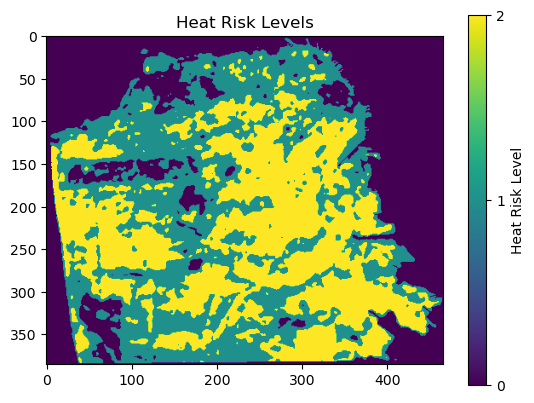

In [ ]:

print("\n" + "=" * 70)
print("STEP 6: MODEL EVALUATION")
print("=" * 70 + "\n")

# ----------------------------------------------------------------------------
# 6.1: Compare Model Performance
# ----------------------------------------------------------------------------

print("6.1 Comparing model performance...")

# Create comparison table
comparison_data = []
for name, res in results.items():
    comparison_data.append({
        'Model': name,
        'Accuracy': res['accuracy'],
        'F1-Score': res['f1'],
        'ROC-AUC': res['auc'],
        'CV F1 Mean': res['cv_scores'].mean(),
        'CV F1 Std': res['cv_scores'].std()
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('F1-Score', ascending=False)

print("\n" + comparison_df.to_string(index=False))

# Find best model
best_model_name = comparison_df.iloc[0]['Model']
best_f1 = comparison_df.iloc[0]['F1-Score']

print(f"\n    🏆 Best Model: {best_model_name} (F1={best_f1:.3f})")

# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(models))
width = 0.25

ax.bar(x - width, comparison_df['Accuracy'], width, label='Accuracy', alpha=0.8, color='#1976D2')
ax.bar(x, comparison_df['F1-Score'], width, label='F1-Score', alpha=0.8, color='#388E3C')
ax.bar(x + width, comparison_df['ROC-AUC'], width, label='ROC-AUC', alpha=0.8, color='#D32F2F')

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison - NYC Heat Risk', fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
ax.legend()
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/04_model_comparison.png', dpi=300, bbox_inches='tight')
print(f"\n    ✓ Saved: {OUTPUT_DIR}/04_model_comparison.png")
plt.close()



The low risk threshold represents the 33rd percentile of the Heat Risk Index, while the medium risk threshold represents the 67th percentile

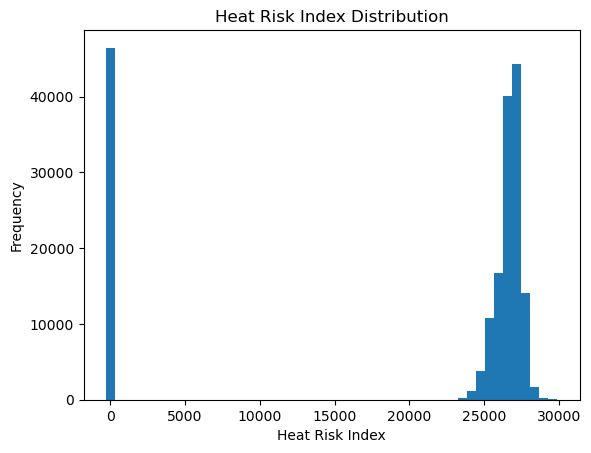

Heat Risk Index min: -270.7974217456927
Heat Risk Index max: 29885.791251114642
Heat Risk Index mean: 19698.526105370966
Low risk threshold: 25508.893921663974
Medium risk threshold: 26880.672794461818


In [ ]:
import matplotlib.pyplot as plt

plt.hist(heat_risk_index.flatten(), bins=50)
plt.title('Heat Risk Index Distribution')
plt.xlabel('Heat Risk Index')
plt.ylabel('Frequency')
plt.show()

print("Heat Risk Index min:", heat_risk_index.min())
print("Heat Risk Index max:", heat_risk_index.max())
print("Heat Risk Index mean:", heat_risk_index.mean())
print("Low risk threshold:", low_risk_threshold)
print("Medium risk threshold:", medium_risk_threshold)


In [ ]:
heat_risk_index_2d = heat_risk_index.reshape(-1, 1)
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(heat_risk_index_2d)
clusters_2d = clusters.reshape(heat_risk_index.shape)

/Users/hbliu/anaconda3/envs/musa650/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0.5, 1.0, 'Heat Risk Index')

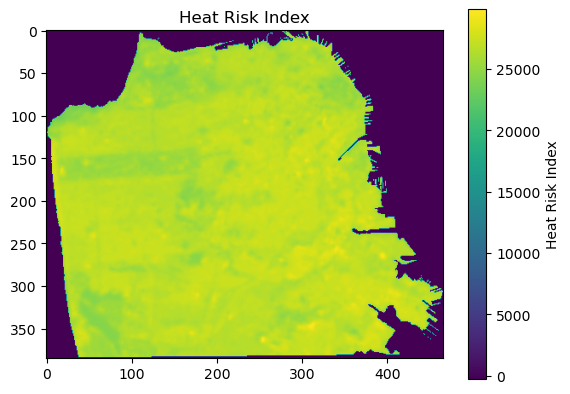

In [ ]:
plt.imshow(heat_risk_index, cmap='viridis')
plt.colorbar(label='Heat Risk Index')
plt.title('Heat Risk Index')

Text(0.5, 1.0, 'KMeans Clusters')

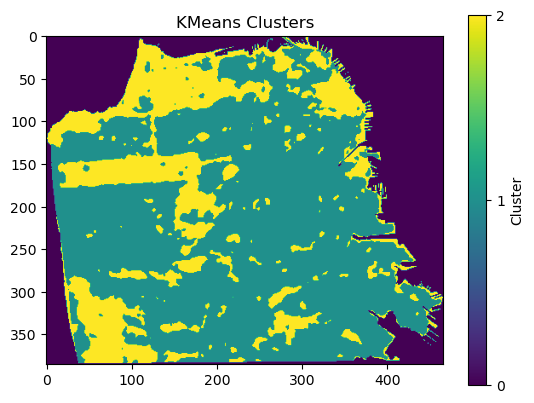

In [ ]:
plt.imshow(clusters_2d, cmap='viridis', vmin=0, vmax=2)
plt.colorbar(ticks=[0, 1, 2], label='Cluster')
plt.title('KMeans Clusters')

## Part 3

In [ ]:
high_risk_threshold = np.percentile(heat_risk_index, 90)
binary_labels = np.zeros_like(heat_risk_index, dtype=int)
binary_labels[heat_risk_index > high_risk_threshold] = 1

X = heat_risk_index.reshape(-1, 1)
y = binary_labels.reshape(-1, 1)
valid_mask = ~np.isnan(X)
X = X[valid_mask].reshape(-1, 1)
y = y[valid_mask].reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## MODEL 1 - Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train.ravel())
y_pred_rf = rf.predict(X_test)

print("Random Forest Classifier:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred_rf))


Random Forest Classifier:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     48363
           1       1.00      1.00      1.00      5460

    accuracy                           1.00     53823
   macro avg       1.00      1.00      1.00     53823
weighted avg       1.00      1.00      1.00     53823

Confusion Matrix:
[[48363     0]
 [    0  5460]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     48363
           1       1.00      1.00      1.00      5460

    accuracy                           1.00     53823
   macro avg       1.00      1.00      1.00     53823
weighted avg       1.00      1.00      1.00     53823

Accuracy Score:
1.0


## MODEL 2 -  Logistic Regression

In [ ]:
logreg = LogisticRegression(random_state=0, max_iter=5000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

Confusion Matrix:
[[34521 13842]
 [ 5460     0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.71      0.78     48363
           1       0.00      0.00      0.00      5460

    accuracy                           0.64     53823
   macro avg       0.43      0.36      0.39     53823
weighted avg       0.78      0.64      0.70     53823

Accuracy Score:
0.6413800791483195


/Users/hbliu/anaconda3/envs/musa650/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## MODEL 3 - SVM

In [ ]:

svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train, y_train.ravel())
y_pred_svm = svm.predict(X_test)
print("SVM Classifier:")
print(classification_report(y_test, y_pred_svm))


SVM Classifier:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     48363
           1       1.00      0.95      0.98      5460

    accuracy                           1.00     53823
   macro avg       1.00      0.98      0.99     53823
weighted avg       1.00      1.00      1.00     53823

